<a href="https://colab.research.google.com/github/mervedin/ibb_data/blob/master/get_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Forecasting

This notebook written to get started quickly with the dam dataset. The dam dataset is a combination of two different datasets.

Orginal dam dataset: https://data.ibb.gov.tr/dataset/istanbul-dam-occupany-rates-data

The weather dataset: https://www.kaggle.com/vonline9/weather-istanbul-data-20092019



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

In [2]:
#read the dataset from github
url = "https://raw.githubusercontent.com/mervedin/ibb_data/master/data-csv-files/dam_istanbul_weather.csv"
data = pd.read_csv(url)

In [3]:
data.head()

,DATE,GENERAL_DAM_OCCUPANCY_RATE,GENERAL_DAM_RESERVED_WATER,DateTime,Condition,Rain,MaxTemp,MinTemp,SunRise,SunSet,MoonRise,MoonSet,AvgWind,AvgHumidity,AvgPressure
0,2009-01-01,34.51,300,01.01.2009,Partly cloudy,0.23,5,2,08:29:00,17:47:00,11:9:00,22:39:00,10,90,1027
1,2009-01-02,34.87,303,01.02.2009,Cloudy,0.02,7,3,08:15:00,18:21:00,10:44:00,NaN,15,86,1019
2,2009-01-03,35.28,306,01.03.2009,Partly cloudy,0.26,8,1,07:39:00,18:55:00,9:17:00,12:0:00,11,84,1020
3,2009-01-04,35.88,312,01.04.2009,Sunny,0.00,17,9,06:48:00,19:29:00,10:17:00,1:22:00,17,69,1017
4,2009-01-05,37.32,324,01.05.2009,Partly cloudy,2.23,20,10,06:02:00,20:1:00,11:45:00,1:49:00,10,75,1007


In [4]:
#drop unnecessary columns
data = data.drop(["GENERAL_DAM_RESERVED_WATER", "DateTime", "SunRise", "SunSet", "MoonSet", "MoonRise", "AvgWind", "AvgPressure"], axis=1)

#redefine columns' name
data.columns = ["date", "dam_occupancy", "weather", "rain", "max_temp", "min_temp", "avg_hum"]

In [5]:
data.head()

,date,dam_occupancy,weather,rain,max_temp,min_temp,avg_hum
0,2009-01-01,34.51,Partly cloudy,0.23,5,2,90
1,2009-01-02,34.87,Cloudy,0.02,7,3,86
2,2009-01-03,35.28,Partly cloudy,0.26,8,1,84
3,2009-01-04,35.88,Sunny,0.00,17,9,69
4,2009-01-05,37.32,Partly cloudy,2.23,20,10,75


In [6]:
#check whether there is any null value
data.isna().sum()

date             0
dam_occupancy    0
weather          0
rain             0
max_temp         0
min_temp         0
avg_hum          0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896 entries, 0 to 3895
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3896 non-null   object 
 1   dam_occupancy  3896 non-null   float64
 2   weather        3896 non-null   object 
 3   rain           3896 non-null   float64
 4   max_temp       3896 non-null   int64  
 5   min_temp       3896 non-null   int64  
 6   avg_hum        3896 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 213.2+ KB


There are two columns that they have object data type, date and weather. We should convert date column to datatime data type and for weather column we should choose a way to present that knowledge as a numeric.  We can use label encoding or one-hot encoding. In our situation weather column is ordinal and using label encoding would be more appropriate.

In [8]:
#convert date column's data type to datetime
data["date"] = pd.to_datetime(data["date"])

#use date column as an index
data.set_index("date", inplace=True)
data.sort_index(inplace=True)
data.head()

,dam_occupancy,weather,rain,max_temp,min_temp,avg_hum
date,,,,,,
2009-01-01,34.51,Partly cloudy,0.23,5,2,90
2009-01-02,34.87,Cloudy,0.02,7,3,86
2009-01-03,35.28,Partly cloudy,0.26,8,1,84
2009-01-04,35.88,Sunny,0.00,17,9,69
2009-01-05,37.32,Partly cloudy,2.23,20,10,75


Before using label encoder we divide the dataset into two part, train and test, so we won't cause any data leakage.

In [9]:
split_index = int(data.shape[0]*0.8)
train = data.iloc[:split_index, :]
test = data.iloc[split_index:, :]

print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (3116, 6)
test shape:  (780, 6)


There is one more problem with weather column. It has lots of different values.

In [10]:
data.weather.value_counts()

Sunny                                  2242
Partly cloudy                           781
Overcast                                427
Cloudy                                  258
Patchy rain possible                     54
Thundery outbreaks possible              45
Light rain shower                        23
Light rain                               11
Moderate or heavy rain shower             8
Light drizzle                             6
Moderate rain                             5
Mist                                      5
Blizzard                                  4
Light sleet                               4
Patchy light rain with thunder            3
Torrential rain shower                    3
Moderate or heavy rain with thunder       3
Heavy rain                                3
Fog                                       2
Patchy light drizzle                      2
Moderate or heavy snow showers            2
Moderate or heavy sleet                   1
Moderate snow                   

If a weather condition has less than 11 examples, group them as a new condition "other".

Note: There could be more accurate ways to do it but that was the fast one. You can work on it.

In [11]:
weather_cond = data.weather.value_counts()
other_weather = list(weather_cond[weather_cond < 11].index)
data["weather"] = data["weather"].apply(lambda x: "other" if x in other_weather else x)

In [12]:
data.weather.value_counts()

Sunny                          2242
Partly cloudy                   781
Overcast                        427
Cloudy                          258
other                            55
Patchy rain possible             54
Thundery outbreaks possible      45
Light rain shower                23
Light rain                       11
Name: weather, dtype: int64

Finally, we can encode our weather column.


In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train["weather"] = le.fit_transform(train["weather"])
test["weather"] = le.transform(test["weather"])

Scaling data will help to  gradient descent converge much faster with scaling than without it.

Additional resource: https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

In [14]:
#scale the data between zero and one
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=data.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=data.columns)

Time series data requires preparation before it can be used to train a supervised learning model, such as a deep learning model.

Read for more info: https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [15]:
"""
This is a custom function to convert raw dataset to sequences.

inputs:
  df(pandas.DataFrame): input dataset
  window_size(int): how many historical data do we need for our prediction
  predict(int): how many lags after do we want to forecast

outputs:
  trainX(numpy.array): features
  trainY(numpy.array): target

  example: if we have a daily dataset and we want to forecast 5 days later 
  in the future using last 10 days values function values would be like that:
  prepare_dataset(df, 5, 10)

"""
def prepare_dataset(df, window_size=7, predict=14):
    trainX = []
    trainY = []
    for i in range(window_size, df.shape[0]-predict+1):
        trainX.append(df.iloc[i-window_size:i, :])
        trainY.append(df.iloc[i+predict-1, 0])
    return np.array(trainX), np.array(trainY)

### Example using the custom function

In [16]:
toy_data = pd.DataFrame({"target": np.random.randint(0, 30, 10), "feature": np.random.randint(40, 70, 10)})
print(toy_data)

   target  feature
0      21       59
1      14       42
2      26       46
3       0       59
4       3       66
5       8       60
6       9       46
7      12       65
8       8       42
9       8       43


In [17]:
x, y = prepare_dataset(toy_data, 2, 1)
print(x)

[[[21 59]
  [14 42]]

 [[14 42]
  [26 46]]

 [[26 46]
  [ 0 59]]

 [[ 0 59]
  [ 3 66]]

 [[ 3 66]
  [ 8 60]]

 [[ 8 60]
  [ 9 46]]

 [[ 9 46]
  [12 65]]

 [[12 65]
  [ 8 42]]]


In [18]:
print(y)

[26  0  3  8  9 12  8  8]


### Getting sequences with TimeseriesGenerator

You can use TimeseriesGenerator to get same results. This is result of toy dataset using same parameters.

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

x = TimeseriesGenerator(toy_data, toy_data.iloc[:, 0], 2)

In [20]:
x[0]

(array([[[21, 59],
         [14, 42]],
 
        [[14, 42],
         [26, 46]],
 
        [[26, 46],
         [ 0, 59]],
 
        [[ 0, 59],
         [ 3, 66]],
 
        [[ 3, 66],
         [ 8, 60]],
 
        [[ 8, 60],
         [ 9, 46]],
 
        [[ 9, 46],
         [12, 65]],
 
        [[12, 65],
         [ 8, 42]]]), array([26,  0,  3,  8,  9, 12,  8,  8]))

In [21]:
train_x, train_y = prepare_dataset(train_scaled)
test_x, test_y = prepare_dataset(test_scaled)

print("train_x shape: ", train_x.shape, " train_y shape: ", train_y.shape)
print("test_x shape: ", test_x.shape, " test_y shape: ", test_y.shape)

train_x shape:  (3096, 7, 6)  train_y shape:  (3096,)
test_x shape:  (760, 7, 6)  test_y shape:  (760,)


## Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(6, activation="relu", input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(LSTM(6, activation="relu"))
model.add(Dense(1, activation="linear"))

es = EarlyStopping(monitor='val_mean_absolute_error', patience=2)
model.compile(optimizer=Adam(learning_rate=0.0005), loss="mean_absolute_error", metrics=["mean_absolute_error"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 6)              312       
_________________________________________________________________
lstm_1 (LSTM)                (None, 6)                 312       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 631
Trainable params: 631
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(train_x, train_y, epochs=300, validation_split=0.2, callbacks=[es])

Epoch 1/300
78/78 [==============================] - 3s 15ms/step - loss: 0.8062 - mean_absolute_error: 0.8062 - val_loss: 0.5904 - val_mean_absolute_error: 0.5904
Epoch 2/300
78/78 [==============================] - 1s 7ms/step - loss: 0.5614 - mean_absolute_error: 0.5614 - val_loss: 0.3070 - val_mean_absolute_error: 0.3070
Epoch 3/300
78/78 [==============================] - 1s 7ms/step - loss: 0.2912 - mean_absolute_error: 0.2912 - val_loss: 0.1822 - val_mean_absolute_error: 0.1822
Epoch 4/300
78/78 [==============================] - 1s 7ms/step - loss: 0.2174 - mean_absolute_error: 0.2174 - val_loss: 0.1736 - val_mean_absolute_error: 0.1736
Epoch 5/300
78/78 [==============================] - 1s 7ms/step - loss: 0.1815 - mean_absolute_error: 0.1815 - val_loss: 0.1227 - val_mean_absolute_error: 0.1227
Epoch 6/300
78/78 [==============================] - 1s 7ms/step - loss: 0.1248 - mean_absolute_error: 0.1248 - val_loss: 0.0981 - val_mean_absolute_error: 0.0981
Epoch 7/300
78/78 [==

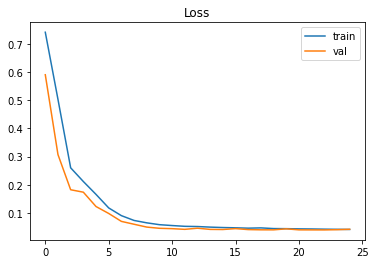

In [25]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train", "val"])
plt.title("Loss")
plt.show()

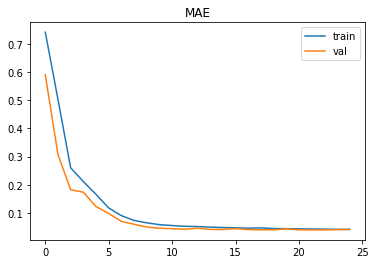

In [26]:
plt.plot(history.history["mean_absolute_error"])
plt.plot(history.history["val_mean_absolute_error"])
plt.legend(["train", "val"])
plt.title("MAE")
plt.show()

In [27]:
#predicting test examples
predictions = model.predict(test_x)
print("Test mean absolute error: ", mean_absolute_error(test_y, predictions))

Test mean absolute error:  0.04234668242542841


In [28]:
#converting prediction values back to orijinal range
forecast_copies = np.repeat(predictions, test.shape[1], axis=1)   #coping predictions to avoid getting error from scaler
forecast = scaler.inverse_transform(forecast_copies)[:, 0]

In [29]:
df_preds = pd.DataFrame({"actual_rate": test["dam_occupancy"][20:], "forecast": forecast})
df_preds.head()

,actual_rate,forecast
date,,
2017-08-04,69.78,71.194237
2017-08-05,69.49,71.401680
2017-08-06,69.21,72.421280
2017-08-07,68.91,71.898300
2017-08-08,68.59,69.428230


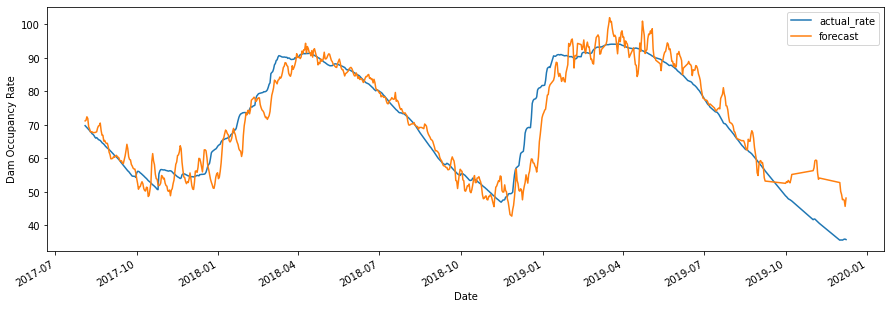

In [30]:
df_preds.plot(figsize=(15, 5))
plt.xlabel("Date")
plt.ylabel("Dam Occupancy Rate")
plt.show()